In [1]:
%matplotlib inline
import os
import numpy as np
from tqdm import tqdm

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import get_CIFAR10, get_SVHN
from datasets import get_MNIST, get_NOTFMNIST
from model import Glow

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Collect data

In [3]:
batch_size = 32

In [4]:
mnist_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

svhn_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
mnist_train_dataset = dsets.MNIST(root='./MNIST/', 
                                   train=True, 
                                   transform=mnist_transform,
                                   download=True)

mnist_test_dataset = dsets.MNIST(root='./MNIST/', 
                                  train=False, 
                                  transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
fmnist_train_dataset = dsets.FashionMNIST(root='./FASHION_MNIST/', 
                                   train=True, 
                                   transform=mnist_transform,
                                   download=True)

fmnist_test_dataset = dsets.FashionMNIST(root='./FASHION_MNIST/', 
                                  train=False, 
                                  transform=mnist_transform)

fmnist_train_loader = torch.utils.data.DataLoader(dataset=fmnist_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=True)

fmnist_test_loader = torch.utils.data.DataLoader(dataset=fmnist_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [7]:
cifar_train_dataset = dsets.CIFAR10(root='./CIFAR/', 
                                   train=True, 
                                   transform=cifar_transform,
                                   download=True)

cifar_test_dataset = dsets.CIFAR10(root='./CIFAR/', 
                                  train=False, 
                                  transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(dataset=cifar_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=True)

cifar_test_loader = torch.utils.data.DataLoader(dataset=cifar_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Files already downloaded and verified


In [8]:
svhn_train_dataset = dsets.SVHN(root='./SVHN/', 
                                   split="train", 
                                   transform=svhn_transform,
                                   download=True)

svhn_test_dataset = dsets.SVHN(root='./SVHN/', 
                                  split="test", 
                                  transform=svhn_transform,
                                  download=True)

svhn_train_loader = torch.utils.data.DataLoader(dataset=svhn_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=True)

svhn_test_loader = torch.utils.data.DataLoader(dataset=svhn_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Using downloaded and verified file: ./SVHN/train_32x32.mat
Using downloaded and verified file: ./SVHN/test_32x32.mat


## VAE 

In [9]:
class BaseVAE(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.in_ch = in_ch

        self.encoder = nn.Sequential (
            nn.Conv2d(in_ch, 8, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(1024, 128)

    def loss(self, full_data):
        data = full_data[0]
        res, mu, var = self(noize(data))   
        loss = self.KLloss(mu, var) + self.BCEloss(data, res)
        return loss

    def BCEloss(self, in_image, gen_image=None):
        if gen_image is None:
            gen_image = self(in_image)[0]
        return F.binary_cross_entropy(
            gen_image.view(in_image.shape[0], -1), 
            in_image.view(in_image.shape[0], -1), 
            reduction="sum")

    def KLloss(self, mu, var):
        return 0.5 * torch.sum(mu**2 + torch.exp(var) - var - 1)

class MnistVAE(BaseVAE):
    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(128, 7 * 7 * 64)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 256, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, self.in_ch, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        sh = x.shape
        enc = self.encoder(x)
        mu, var = self.fc1(enc), self.fc2(enc)
        sample = torch.exp(0.5 * var)
        r = torch.randn(*mu.size())
        if torch.cuda.is_available():
            r = r.type(torch.FloatTensor).to(device)
        z = mu + sample * r
        dec = self.fc(z).view(-1, 64, 7, 7)
        res = self.decoder(dec)
        return res, mu, var

    def sample(self):
        r = torch.randn(128).cuda()
        dec = self.fc(r).view(-1, 64, 7, 7)
        res = self.decoder(dec)
        return res.detach().cpu().numpy()[0][0]

class CifarVAE(BaseVAE):
    def __init__(self):
        super().__init__(in_ch=3)

        self.fc = nn.Linear(128, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, bias=False, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, bias=False, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, bias=False, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(128, self.in_ch, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        sh = x.shape
        enc = self.encoder(x)
        mu, var = self.fc1(enc), self.fc2(enc)
        sample = torch.exp(0.5 * var)
        r = torch.randn(*mu.size())
        if torch.cuda.is_available():
            r = r.type(torch.FloatTensor).to(device)
        z = mu + sample * r
        dec = self.fc(z).view(-1, 128, 4, 4)
        res = self.decoder(dec)
        return res, mu, var

    def sample(self):
        r = torch.randn(128).cuda()
        dec = self.fc(r).view(-1, 128, 4, 4)
        res = self.decoder(dec)
        return res[0].view(32, 32, -1).detach().cpu().numpy()

In [36]:
class Trainer:
    def __init__(self, model, opt, train_data, 
                 val_data, name, skip_first_steps=10, 
                 n_epochs=100, smoothing=0.6):
        self.model = model
        self.opt = opt
        self.name = name
        self.n_epochs = n_epochs
        self.train_data = train_data
        self.val_data = val_data
        self.smoothing = smoothing
        self.skip_first_steps = skip_first_steps
        self.cur_epoch = 0
        self.train_loss_hist = []
        self.val_loss_hist = []
        self.val_loss_steps = []
        self.pure_train_loss = []
        self.pure_val_loss = []
        self.fig = None
        os.makedirs(name, exist_ok=True)

    def run(self):
        try:
            while self.cur_epoch < self.n_epochs:
                self.train_epoch()
                self.val_epoch()
                self.plot_loss()
                self.save_progress()
                self.cur_epoch += 1
        except KeyboardInterrupt:
            pass
        return self

    def train_epoch(self):
        self.model.train()
        for data, target in tqdm(self.train_data):
            self.opt.zero_grad()
            data = data.type(torch.FloatTensor).to(device)
            loss = self.model.loss((data, target))
            loss.backward()
            self.opt.step()
            loss = loss.item()
            self.pure_train_loss.append(loss)
            if self.smoothing is not None:
                if len(self.train_loss_hist) > 0:
                    loss = (1 - self.smoothing) * loss
                    loss += self.smoothing * self.train_loss_hist[-1]
            self.train_loss_hist.append(loss)

    def val_epoch(self):
        cur_val_loss = []
        pure_val_loss = []
        self.model.eval()
        with torch.no_grad():
            for data, target in tqdm(self.val_data):
                data = data.type(torch.FloatTensor).to(device)
                loss = self.model.loss((data, target))
                loss = loss.item()
                pure_val_loss.append(loss)
                if self.smoothing is not None:
                    if len(cur_val_loss) > 0:
                        loss = (1 - self.smoothing) * loss
                        loss += self.smoothing * cur_val_loss[-1]
                cur_val_loss.append(loss)
        loss = np.mean(cur_val_loss)
        self.val_loss_hist.append(loss)
        loss = np.mean(pure_val_loss)
        self.pure_val_loss.append(loss)
        self.val_loss_steps.append(len(self.train_loss_hist))

    def plot_loss(self):
        clear_output()
        self.fig = plt.figure(figsize=(10, 10))
        plt.title("Loss. Epoch: {}".format(self.cur_epoch), fontsize=15)
        plt.plot(np.arange(self.skip_first_steps, len(self.train_loss_hist)), 
            self.train_loss_hist[self.skip_first_steps:], label='train', zorder=1)    
        plt.scatter(self.val_loss_steps, self.val_loss_hist, 
            marker='+', s=180, c='orange', label='val', zorder=2)
        plt.xlabel('train steps', fontsize=15)
        plt.legend(loc='best', fontsize=15)
        plt.grid()
        plt.show()
        try:
            plt.figure(figsize=(10,10))
            plt.imshow(self.model.sample())
            plt.show()
        except:
            print("No samples")

    def save_progress(self):
        torch.save(self.model.state_dict(), self.name+"/model.torch")
        torch.save(self.opt.state_dict(), self.name+"/opt.torch")
        self.fig.savefig(self.name+"/loss.png")
        torch.save(self.train_loss_hist, self.name+"/train_loss.torch")
        torch.save(self.val_loss_hist, self.name+"/val_loss.torch")
        torch.save(self.val_loss_steps, self.name+"/val_steps.torch")
        torch.save(self.pure_train_loss, self.name+"/pure_train.torch")
        torch.save(self.pure_val_loss, self.name+"/pure_val.torch")

def init_weights(x):
    cl = x.__class__.__name__
    if cl.find('BatchNorm2d') != -1:
        nn.init.normal(x.weight.data, 1., 0.02)
        nn.init.constant(x.bias.data, 0.)
    elif cl.find('Conv') != -1:
        nn.init.normal(x.weight.data, 0., 0.02)

def noize(x):
    x += torch.randn(x.shape).to(x.device) * 0.07
    x -= x.view(x.shape[0], 1, 1, -1).min(dim=-1, keepdim=True)[0].to(x.device)
    x /= x.view(x.shape[0], 1, 1, -1).max(dim=-1, keepdim=True)[0].to(x.device)
    return x

def plot_vae_info(model, train, test, out_test, train_name="train", test_name="test", out_test_name="out_test", title="", num=28):
    def apply(model, dataset, max_len=None):
        clear_output()
        ans = []
        i = 0
        for data, target in tqdm(dataset):
            sh = data.shape
            data = data.view(1, sh[0], sh[1], sh[2]).type(torch.FloatTensor).to(device)
            ans.append(-model.loss((data, target)).item())
            if max_len is not None and i == max_len:
                break
            i += 1
        ans = np.array(ans)
        return ans
    
    num = min([len(train), len(test), len(out_test)])
    train_ans = apply(model, train, num)
    test_ans = apply(model, test, num)
    out_test = apply(model, out_test, num)
    print(train_ans.mean() * np.log(2) / num / num)
    print(test_ans.mean() * np.log(2) / num / num)
    print(out_test.mean() * np.log(2) / num / num)
    fig = plt.figure(figsize=(15, 9))
    plt.hist(train_ans, 50, label=train_name, alpha=0.6)
    plt.hist(test_ans, 50, label=test_name, alpha=0.6)
    plt.hist(out_test, 50, label=out_test_name, alpha=0.6)
    plt.xlabel("log p(x)", fontsize=15)
    plt.title(title, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.show()
    return fig

In [ ]:
epochs = 100

model = MnistVAE().to(device)

model.apply(init_weights)

opt=optim.RMSprop(model.parameters(), lr=1e-4)

trainer = Trainer(model, opt, fmnist_train_loader, fmnist_test_loader, name="vae_fmnist")

trainer.run()

In [ ]:
epochs = 100

model = CifarVAE().to(device)

model.apply(init_weights)

opt=optim.RMSprop(model.parameters(), lr=1e-4)

trainer = Trainer(model, opt, cifar_train_loader, cifar_test_loader, name="vae_cifar")

trainer.run()

GLOW

In [ ]:
!pip install pytorch-ignite

In [ ]:
!python train.py --download --fresh --L 3 --K 8 --hidden_channels 400 --batch_size 32 --epochs 150 --output_dir glow_cifar/

In [ ]:
!python train.py --warmup 5 --download --flow_coupling additive --fresh --L 3 --K 8 --hidden_channels 400 --batch_size 32 --epochs 20 --output_dir cvglow_cifar/

In [ ]:
!python train.py --warmup 10 --download --fresh --L 2 --K 16 --hidden_channels 200 --batch_size 32 --epochs 14 --dataset mnist --output_dir mnist_glow/






  0%|          | 0/10000 [00:00<?, ?it/s]




  0%|          | 37/10000 [00:00<00:27, 359.95it/s]




  1%|          | 73/10000 [00:00<00:27, 359.76it/s]




  1%|          | 109/10000 [00:00<00:27, 358.56it/s]




  1%|▏         | 144/10000 [00:00<00:27, 355.85it/s]




  2%|▏         | 180/10000 [00:00<00:27, 356.22it/s]




  2%|▏         | 216/10000 [00:00<00:27, 352.50it/s]




  3%|▎         | 253/10000 [00:00<00:27, 356.89it/s]




  3%|▎         | 291/10000 [00:00<00:26, 361.81it/s]




  3%|▎         | 329/10000 [00:00<00:26, 364.60it/s]




  4%|▎         | 366/10000 [00:01<00:26, 364.24it/s]




  4%|▍         | 403/10000 [00:01<00:26, 364.24it/s]




  4%|▍         | 440/10000 [00:01<00:26, 363.31it/s]




  5%|▍         | 478/10000 [00:01<00:25, 366.83it/s]




  5%|▌         | 515/10000 [00:01<00:25, 366.71it/s]




  6%|▌         | 553/10000 [00:01<00:25, 369.56it/s]




  6%|▌         | 591/10000 [00:01<00:25, 371.52it/s]




  6%|▋         | 629/10000 [00:01<00:25

-2.949900826332112e-06
-2.958083814322366e-06
-2.934857794237959e-06


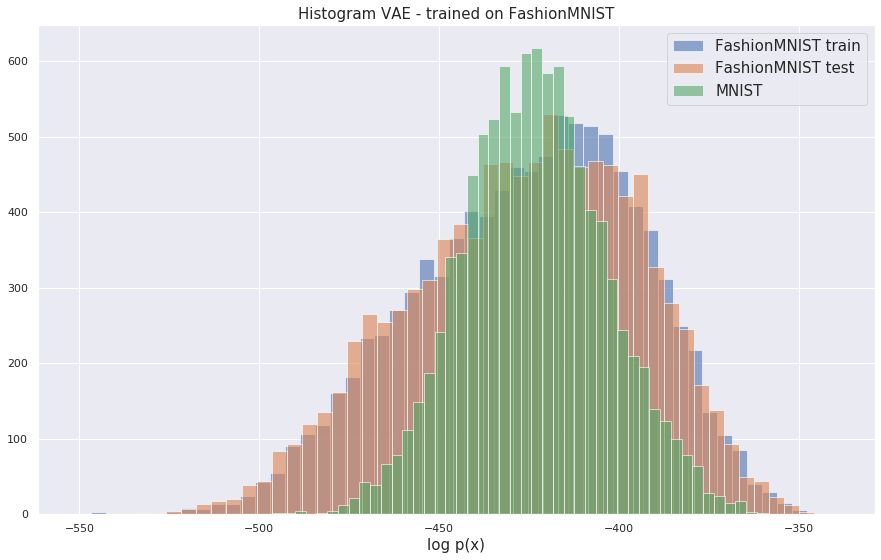

In [37]:
fmnist_model = MnistVAE().to(device)
fmnist_model.load_state_dict(torch.load("vae_fmnist/model.torch"))
vae_mnist = plot_vae_info(fmnist_model, fmnist_train_dataset, fmnist_test_dataset, mnist_test_dataset, 
    "FashionMNIST train", "FashionMNIST test", "MNIST", "Histogram VAE - trained on FashionMNIST")







  0%|          | 0/26032 [00:00<?, ?it/s]





  0%|          | 36/26032 [00:00<01:13, 354.72it/s]





  0%|          | 71/26032 [00:00<01:13, 351.67it/s]





  0%|          | 106/26032 [00:00<01:14, 349.07it/s]





  1%|          | 141/26032 [00:00<01:14, 348.16it/s]





  1%|          | 177/26032 [00:00<01:13, 351.48it/s]





  1%|          | 213/26032 [00:00<01:13, 353.18it/s]





  1%|          | 250/26032 [00:00<01:12, 356.01it/s]





  1%|          | 285/26032 [00:00<01:12, 353.61it/s]





  1%|          | 322/26032 [00:00<01:12, 355.92it/s]





  1%|▏         | 359/26032 [00:01<01:11, 357.60it/s]





  2%|▏         | 395/26032 [00:01<01:11, 356.71it/s]





  2%|▏         | 432/26032 [00:01<01:11, 358.71it/s]





  2%|▏         | 469/26032 [00:01<01:11, 359.30it/s]





  2%|▏         | 505/26032 [00:01<01:11, 359.31it/s]





  2%|▏         | 541/26032 [00:01<01:10, 359.21it/s]





  2%|▏         | 577/26032 [00:01<01:11, 358.41it/s]





  2%|▏         | 613/

-1.2749172345395148e-05
-1.2766693425457335e-05
-1.3331754116409079e-05


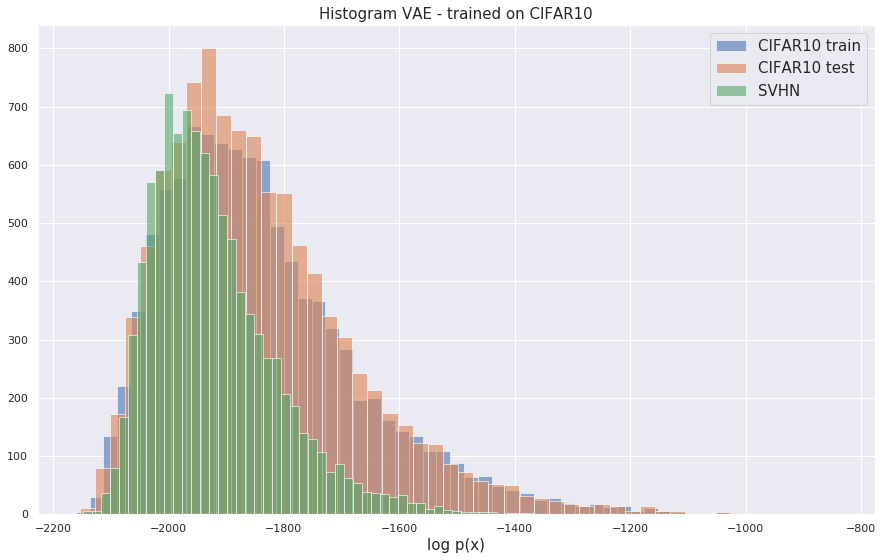







 38%|███▊      | 9980/26032 [00:47<00:45, 355.79it/s]

In [38]:
cifar_model = CifarVAE().to(device)
cifar_model.load_state_dict(torch.load("vae_cifar/model.torch"))
vae_cifar = plot_vae_info(cifar_model, cifar_train_dataset, cifar_test_dataset, svhn_test_dataset, 
    "CIFAR10 train", "CIFAR10 test", "SVHN", "Histogram VAE - trained on CIFAR10", 32)

In [39]:
vae_mnist.savefig("vae_fmnist.png")
vae_cifar.savefig("vae_cifar.png")

In [12]:
device = torch.device("cuda")

def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _ = model(x, y_onehot=y)
            
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

{'K': 8, 'L': 3, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 32, 'cuda': True, 'dataroot': './', 'dataset': 'cifar10', 'download': True, 'epochs': 100000, 'eval_batch_size': 512, 'flow_coupling': 'affine', 'flow_permutation': 'invconv', 'hidden_channels': 400, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'glow_cifar/', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup': 5, 'y_condition': False, 'y_weight': 0.01}
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat
CIFAR NLL tensor(3.5553)
SVHN NLL tensor(2.4485)
CIFAR TRAIN tensor(3.3199)
CIFAR NLL tensor(5252.3296)
SVHN NLL tensor(3617.2664)
CIFAR TRAIN tensor(4904.4854)


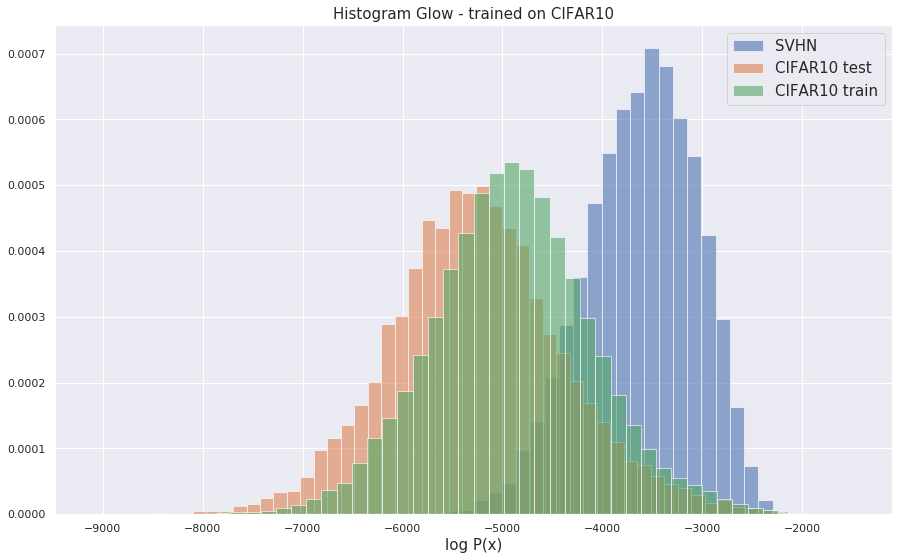

In [19]:
output_folder = 'glow_cifar/'
model_name = 'glow_model_150.pth'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, train_cifar, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], hparams['download'])

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)
cifar_train = compute_nll(train_cifar, model)

print("CIFAR test bpd", torch.mean(cifar_nll))
print("SVHN out bpd", torch.mean(svhn_nll))
print("CIFAR train bpd", torch.mean(cifar_train))

cifar_nll = cifar_nll * (32*32) / np.log(2)
svhn_nll = svhn_nll * (32*32) / np.log(2)
cifar_train = cifar_train * (32*32) / np.log(2)

print("CIFAR test bpd", torch.mean(cifar_nll))
print("SVHN our ", torch.mean(svhn_nll))
print("CIFAR TRAIN", torch.mean(cifar_train))

cifar_glov = plt.figure(figsize=(15, 9))
plt.title("Histogram Glow - trained on CIFAR10", fontsize=15)
plt.xlabel("log P(x)", fontsize=15)
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30, alpha=0.6)
plt.hist(-cifar_nll.numpy(), label="CIFAR10 test", density=True, bins=50, alpha=0.6)
plt.hist(-cifar_train.numpy(), label="CIFAR10 train", density=True, bins=50, alpha=0.6)
plt.legend(fontsize=15)
plt.show()

{'K': 8, 'L': 3, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 32, 'cuda': True, 'dataroot': './', 'dataset': 'cifar10', 'download': True, 'epochs': 100, 'eval_batch_size': 512, 'flow_coupling': 'additive', 'flow_permutation': 'invconv', 'hidden_channels': 400, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'cvglow_cifar/', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup': 5.0, 'y_condition': False, 'y_weight': 0.01}
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat
CIFAR NLL tensor(3.6210)
SVHN NLL tensor(2.4869)
CIFAR TRAIN tensor(3.3911)
CIFAR NLL tensor(5349.4458)
SVHN NLL tensor(3674.0122)
CIFAR TRAIN tensor(5009.6953)


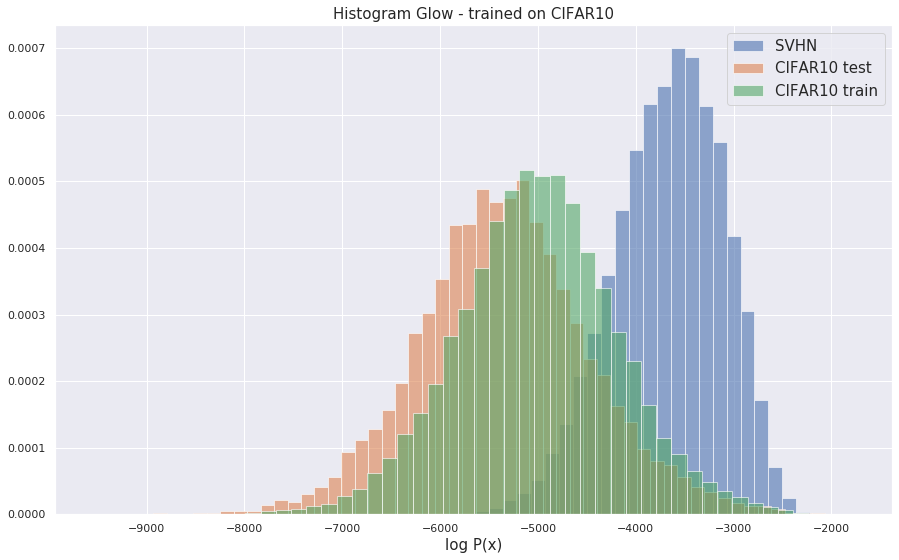

In [20]:
output_folder = 'cvglow_cifar/'
model_name = 'glow_model_100.pth'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, train_cifar, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], hparams['download'])

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)
cifar_train = compute_nll(train_cifar, model)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))
print("CIFAR TRAIN", torch.mean(cifar_train))

cifar_nll = cifar_nll * (32*32) / np.log(2)
svhn_nll = svhn_nll * (32*32) / np.log(2)
cifar_train = cifar_train * (32*32) / np.log(2)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))
print("CIFAR TRAIN", torch.mean(cifar_train))

cifar_cvglow = plt.figure(figsize=(15, 9))
plt.title("Histogram Glow - trained on CIFAR10", fontsize=15)
plt.xlabel("log P(x)", fontsize=15)
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30, alpha=0.6)
plt.hist(-cifar_nll.numpy(), label="CIFAR10 test", density=True, bins=50, alpha=0.6)
plt.hist(-cifar_train.numpy(), label="CIFAR10 train", density=True, bins=50, alpha=0.6)
plt.legend(fontsize=15)
plt.show()

{'K': 16, 'L': 2, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 32, 'cuda': True, 'dataroot': './', 'dataset': 'mnist', 'download': True, 'epochs': 20, 'eval_batch_size': 512, 'flow_coupling': 'affine', 'flow_permutation': 'invconv', 'hidden_channels': 200, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'mnist_glow/', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup': 10.0, 'y_condition': False, 'y_weight': 0.01}
fmnist NLL tensor(3.2117)
mnist NLL tensor(1.9091)
fmnist TRAIN tensor(3.0810)
fmnist NLL tensor(4744.7588)
mnist NLL tensor(2820.3452)
fmnist TRAIN tensor(4551.6377)


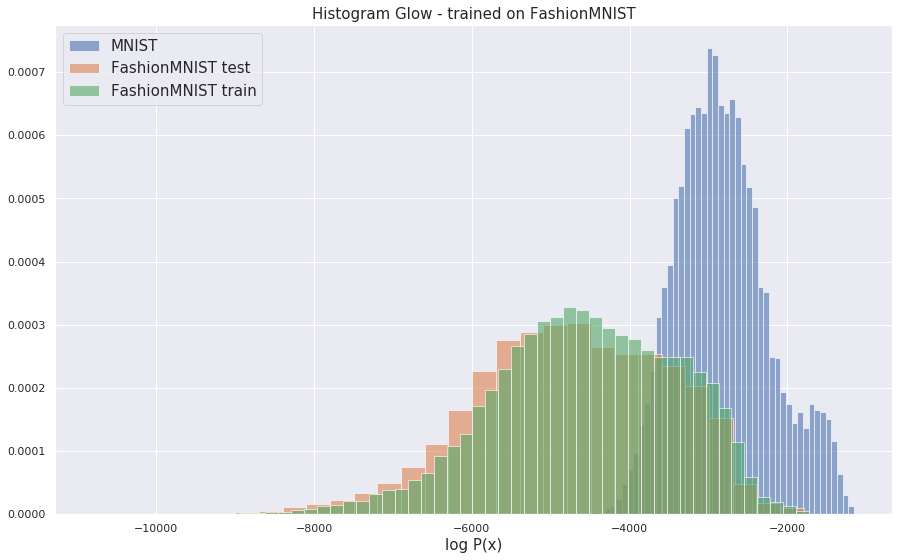

In [23]:
output_folder = 'mnist_glow/'
model_name = 'glow_model_14.pth'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, train_fmnist, test_fmnist = get_MNIST(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_mnist = get_NOTFMNIST(hparams['augment'], hparams['dataroot'], hparams['download'])

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

fmnist_nll = compute_nll(test_fmnist, model)
mnist_nll = compute_nll(test_mnist, model)
fmnist_train = compute_nll(train_fmnist, model)

print("fmnist NLL", torch.mean(fmnist_nll))
print("mnist NLL", torch.mean(mnist_nll))
print("fmnist TRAIN", torch.mean(fmnist_train))

fmnist_nll = fmnist_nll * (32*32) / np.log(2)
mnist_nll = mnist_nll * (32*32) / np.log(2)
fmnist_train = fmnist_train * (32*32) / np.log(2)

print("fmnist NLL", torch.mean(fmnist_nll))
print("mnist NLL", torch.mean(mnist_nll))
print("fmnist TRAIN", torch.mean(fmnist_train))

mnist_glow = plt.figure(figsize=(15, 9))
plt.title("Histogram Glow - trained on FashionMNIST", fontsize=15)
plt.xlabel("log P(x)", fontsize=15)
plt.hist(-mnist_nll.numpy(), label="MNIST", density=True, bins=50, alpha=0.6)
plt.hist(-fmnist_nll.numpy(), label="FashionMNIST test", density=True, bins=30, alpha=0.6)
plt.hist(-fmnist_train.numpy(), label="FashionMNIST train", density=True, bins=50, alpha=0.6)
plt.legend(fontsize=15)
plt.show()

In [25]:
cifar_glov.savefig("cifar_glow.png")
cifar_cvglow.savefig("cifar_cvglow.png")
mnist_glow.savefig("mnist_glow.png")